In [1]:
from fastai.vision.all import *
from pandas_path import path
import rasterio
import xarray
import xrspatial.multispectral as ms

In [2]:
img_path = Path('data/train_features/')
mask_path = Path('data/train_labels/')

In [3]:
df = pd.read_csv('data/train_metadata.csv')

In [4]:
df.head()

chip_id  location              datetime                   cloudpath
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp
1    adwu  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwu
2    adwz  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwz
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp
4    aeaj  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aeaj

In [5]:
def split_by_location(df, val_pct = 0.2):
    locations = df.location.unique()
    n_locations = int(val_pct * len(locations))
    chosen_locations = random.choices(locations, k = n_locations)
    
    df['is_valid'] = False
    df.loc[df['location'].isin(chosen_locations), 'is_valid'] = True

In [6]:
split_by_location(df)

In [7]:
## Copied from https://www.drivendata.co/blog/cloud-cover-benchmark/

BANDS = ["B02", "B03", "B04", "B08"]

def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        assert df["label_path"].path.exists().all()

    return df


train_meta = add_paths(df, img_path, mask_path, BANDS)
train_meta.head()

chip_id  location              datetime                   cloudpath  \
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp   
1    adwu  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwu   
2    adwz  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwz   
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp   
4    aeaj  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aeaj   

   is_valid                          B02_path  \
0     False  data/train_features/adwp/B02.tif   
1     False  data/train_features/adwu/B02.tif   
2     False  data/train_features/adwz/B02.tif   
3     False  data/train_features/adxp/B02.tif   
4     False  data/train_features/aeaj/B02.tif   

                           B03_path                          B04_path  \
0  data/train_features/adwp/B03.tif  data/train_features/adwp/B04.tif   
1  data/train_features/adwu/B03.tif  data/train_features/adwu/B04.tif   
2  data/train_features/adwz/B03.tif  data/train_features/adwz/B04.tif   
3  data/train_features/adxp/B03.tif  data/train_features/adxp/B04.tif   
4  data/train_features/aeaj/B03.tif  data/train_features/aeaj/B04.tif   

                           B08_path                  label_path  
0  data/train_features/adwp/B08.tif  data/train_labels/adwp.tif  
1  data/train_features/adwu/B08.tif  data/train_labels/adwu.tif  
2  data/train_features/adwz/B08.tif  data/train_labels/adwz.tif  
3  data/train_features/adxp/B08.tif  data/train_labels/adxp.tif  
4  data/train_features/aeaj/B08.tif  data/train_labels/aeaj.tif

In [18]:
def get_array(filepath):
    return np.array(Image.open(filepath))

In [23]:
chips = df.chip_id.unique()

In [24]:
from tqdm import tqdm

In [27]:
chip = chips[0]
loc_chip = df['chip_id'] == chip

df.loc[loc_chip, 'B02_path'].item()

Path('data/train_features/adwp/B02.tif')

In [28]:
for band in BANDS:
    print(f'Processing band: {band}')
    for chip in tqdm(chips):
        loc_chip = df['chip_id'] == chip
        
        fn = df.loc[loc_chip, f'{band}_path'].item()
        
        df.loc[loc_chip, f'{band}_min'] = get_array(fn).min()
        df.loc[loc_chip, f'{band}_max'] = get_array(fn).max()

  0%|          | 25/11748 [00:00<00:46, 249.45it/s]

Processing band: B02


  0%|          | 20/11748 [00:00<01:00, 192.67it/s]

Processing band: B03


  0%|          | 20/11748 [00:00<01:00, 195.26it/s]

Processing band: B04


  0%|          | 21/11748 [00:00<00:57, 203.71it/s]

Processing band: B08


100%|██████████| 11748/11748 [01:02<00:00, 187.85it/s]


In [29]:
df.head()

chip_id  location              datetime                   cloudpath  \
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp   
1    adwu  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwu   
2    adwz  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwz   
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp   
4    aeaj  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aeaj   

   is_valid                          B02_path  \
0     False  data/train_features/adwp/B02.tif   
1     False  data/train_features/adwu/B02.tif   
2     False  data/train_features/adwz/B02.tif   
3     False  data/train_features/adxp/B02.tif   
4     False  data/train_features/aeaj/B02.tif   

                           B03_path                          B04_path  \
0  data/train_features/adwp/B03.tif  data/train_features/adwp/B04.tif   
1  data/train_features/adwu/B03.tif  data/train_features/adwu/B04.tif   
2  data/train_features/adwz/B03.tif  data/train_features/adwz/B04.tif   
3  data/train_features/adxp/B03.tif  data/train_features/adxp/B04.tif   
4  data/train_features/aeaj/B03.tif  data/train_features/aeaj/B04.tif   

                           B08_path                  label_path  B02_min  \
0  data/train_features/adwp/B08.tif  data/train_labels/adwp.tif    522.0   
1  data/train_features/adwu/B08.tif  data/train_labels/adwu.tif    447.0   
2  data/train_features/adwz/B08.tif  data/train_labels/adwz.tif    542.0   
3  data/train_features/adxp/B08.tif  data/train_labels/adxp.tif   7524.0   
4  data/train_features/aeaj/B08.tif  data/train_labels/aeaj.tif   5568.0   

   B02_max  B03_min  B03_max  B04_min  B04_max  B08_min  B08_max  
0   9600.0    648.0   9312.0    556.0   8928.0    534.0   8488.0  
1  12552.0    529.0  12096.0    398.0  11520.0    644.0  11240.0  
2  12424.0    544.0  11728.0    480.0  11168.0    453.0  10560.0  
3  14016.0   7076.0  13168.0   6676.0  12416.0   5876.0  11240.0  
4  15408.0   5124.0  14232.0   4732.0  13272.0   4380.0  12696.0

In [33]:
import seaborn as sns

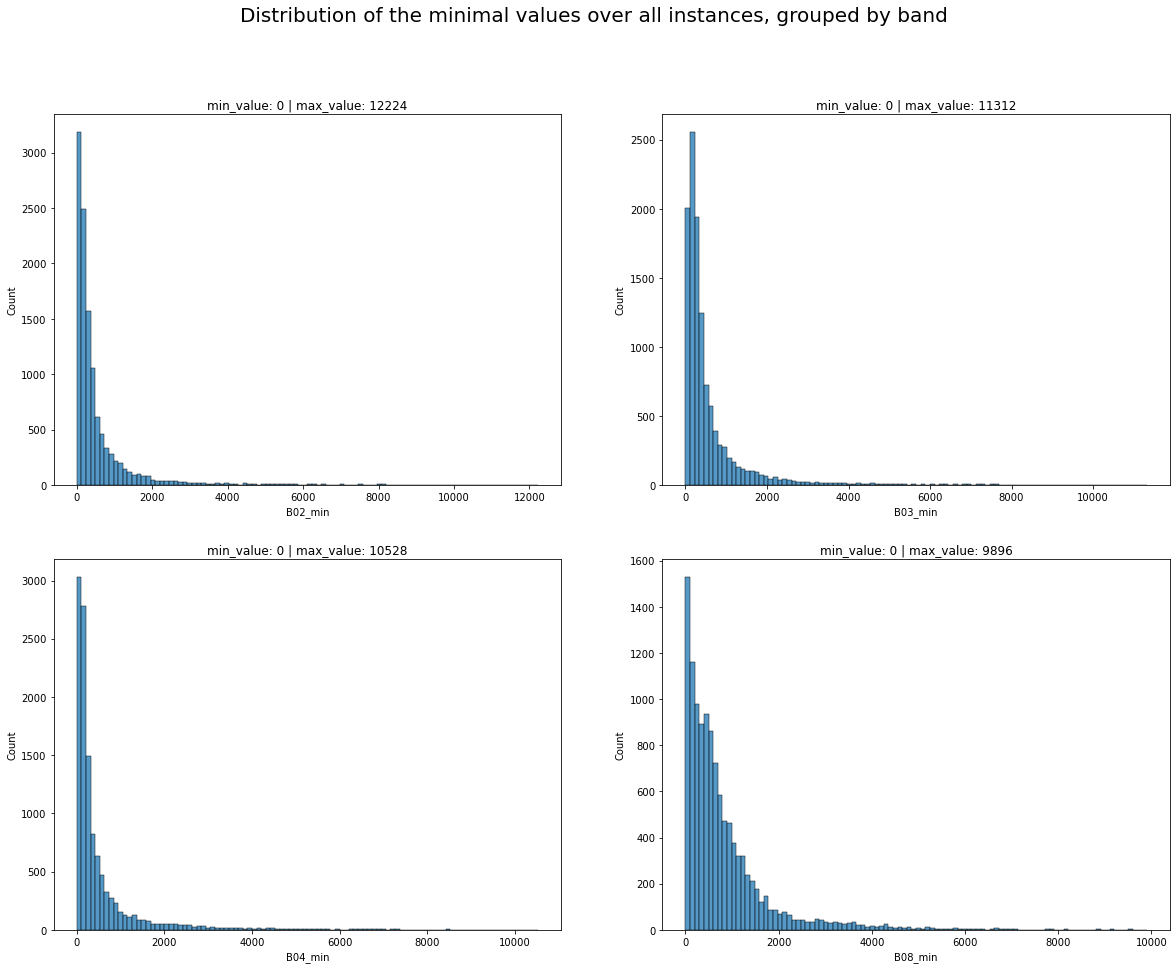

In [50]:
fig, axs = plt.subplots(2,2, figsize = (20, 15))
axs = axs.flatten()
for i,band in enumerate(BANDS):
    fig.suptitle('Distribution of the minimal values over all instances, grouped by band', fontsize=20)
    sns.histplot(df[f'{band}_min'], ax = axs[i], bins=100)
    axs[i].set_title(f'min_value: {int(df[f"{band}_min"].min())} | max_value: {int(df[f"{band}_min"].max())}')

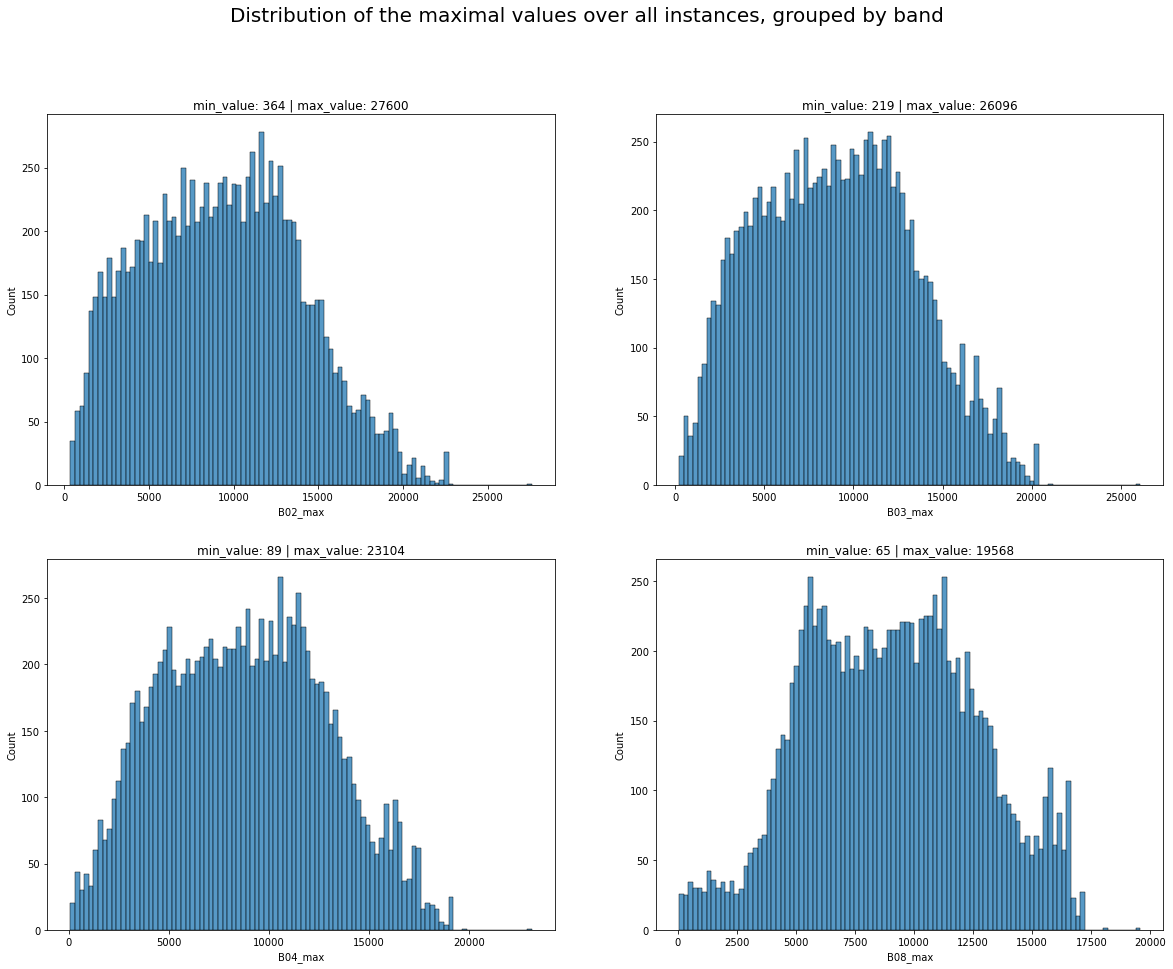

In [51]:
fig, axs = plt.subplots(2,2, figsize = (20, 15))
axs = axs.flatten()
for i,band in enumerate(BANDS):
    fig.suptitle('Distribution of the maximal values over all instances, grouped by band', fontsize=20)
    sns.histplot(df[f'{band}_max'], ax = axs[i], bins=100)
    axs[i].set_title(f'min_value: {int(df[f"{band}_max"].min())} | max_value: {int(df[f"{band}_max"].max())}')

In [103]:
df[df['B08_max'] < 2700]

chip_id    location              datetime                   cloudpath  \
11       aege    Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aege   
58       afqf    Chifunfu  2020-04-29T08:20:47Z  az://./train_features/afqf   
60       aftk    Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aftk   
99       agrp    Chifunfu  2020-04-29T08:20:47Z  az://./train_features/agrp   
106      agvj    Chifunfu  2020-04-29T08:20:47Z  az://./train_features/agvj   
...       ...         ...                   ...                         ...   
11688    zwck  Launceston  2020-09-06T00:08:20Z  az://./train_features/zwck   
11695    zwgd  Launceston  2020-09-06T00:08:20Z  az://./train_features/zwgd   
11716    zwwd  Launceston  2020-09-06T00:08:20Z  az://./train_features/zwwd   
11729    zxju  Launceston  2020-09-06T00:08:20Z  az://./train_features/zxju   
11733    zxon  Launceston  2020-09-06T00:08:20Z  az://./train_features/zxon   

       is_valid                          B02_path  \
11        False  data/train_features/aege/B02.tif   
58        False  data/train_features/afqf/B02.tif   
60        False  data/train_features/aftk/B02.tif   
99        False  data/train_features/agrp/B02.tif   
106       False  data/train_features/agvj/B02.tif   
...         ...                               ...   
11688     False  data/train_features/zwck/B02.tif   
11695     False  data/train_features/zwgd/B02.tif   
11716     False  data/train_features/zwwd/B02.tif   
11729     False  data/train_features/zxju/B02.tif   
11733     False  data/train_features/zxon/B02.tif   

                               B03_path                          B04_path  \
11     data/train_features/aege/B03.tif  data/train_features/aege/B04.tif   
58     data/train_features/afqf/B03.tif  data/train_features/afqf/B04.tif   
60     data/train_features/aftk/B03.tif  data/train_features/aftk/B04.tif   
99     data/train_features/agrp/B03.tif  data/train_features/agrp/B04.tif   
106    data/train_features/agvj/B03.tif  data/train_features/agvj/B04.tif   
...                                 ...                               ...   
11688  data/train_features/zwck/B03.tif  data/train_features/zwck/B04.tif   
11695  data/train_features/zwgd/B03.tif  data/train_features/zwgd/B04.tif   
11716  data/train_features/zwwd/B03.tif  data/train_features/zwwd/B04.tif   
11729  data/train_features/zxju/B03.tif  data/train_features/zxju/B04.tif   
11733  data/train_features/zxon/B03.tif  data/train_features/zxon/B04.tif   

                               B08_path                  label_path  B02_min  \
11     data/train_features/aege/B08.tif  data/train_labels/aege.tif    683.0   
58     data/train_features/afqf/B08.tif  data/train_labels/afqf.tif    530.0   
60     data/train_features/aftk/B08.tif  data/train_labels/aftk.tif    289.0   
99     data/train_features/agrp/B08.tif  data/train_labels/agrp.tif    478.0   
106    data/train_features/agvj/B08.tif  data/train_labels/agvj.tif    320.0   
...                                 ...                         ...      ...   
11688  data/train_features/zwck/B08.tif  data/train_labels/zwck.tif    179.0   
11695  data/train_features/zwgd/B08.tif  data/train_labels/zwgd.tif    192.0   
11716  data/train_features/zwwd/B08.tif  data/train_labels/zwwd.tif    210.0   
11729  data/train_features/zxju/B08.tif  data/train_labels/zxju.tif    230.0   
11733  data/train_features/zxon/B08.tif  data/train_labels/zxon.tif    177.0   

       B02_max  B03_min  B03_max  B04_min  B04_max  B08_min  B08_max  
11      2626.0    691.0   2584.0    631.0   2478.0    642.0   2418.0  
58       837.0    589.0    881.0    531.0    786.0    467.0    692.0  
60      2024.0    285.0   1982.0    240.0   1832.0    217.0   1726.0  
99      2234.0    508.0   2184.0    450.0   2010.0    422.0   2684.0  
106     1970.0    346.0   1968.0    311.0   1808.0    292.0   1650.0  
...        ...      ...      ...      ...      ...      ...      ...  
11688    899.0    126.0    771.0     

In [165]:
def mask_img(chip):
    mask_path = df.loc[df['chip_id'] == chip, 'label_path'].item()
    mask = Image.open(mask_path).convert('L')
    
    return np.array(mask)

In [245]:
def show_masked(chip, debug = False):
    img = true_color_img(chip)
    mask = mask_img(chip)
    
    normal_img = np.array(img / 255)
    normal_img[...,2] *= (1 - 0.3 * mask)
    
    contour = np.array(Image.fromarray(mask).filter(ImageFilter.FIND_EDGES))
    normal_img[np.where(contour)] = (1,1,0,1)
    
    plt.figure(figsize = (20, 15))
    plt.imshow(normal_img)
    
    if debug:
        return normal_img, mask, contour

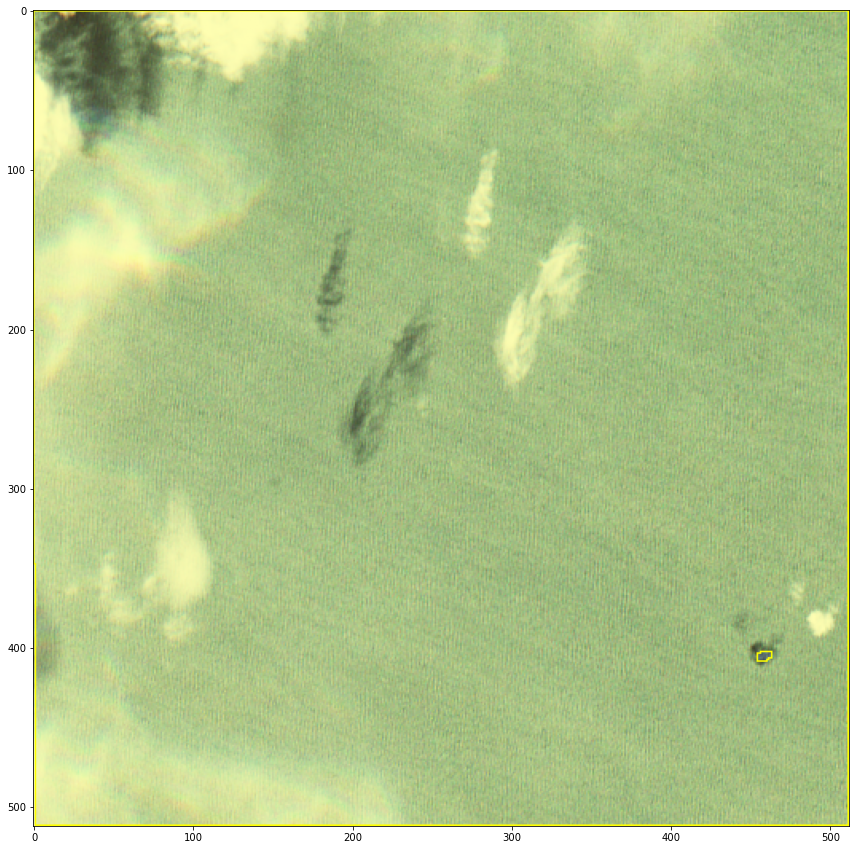

In [248]:
normal_img, mask, contour = show_masked('aftk', debug = True)

In [253]:
import cv2

261947


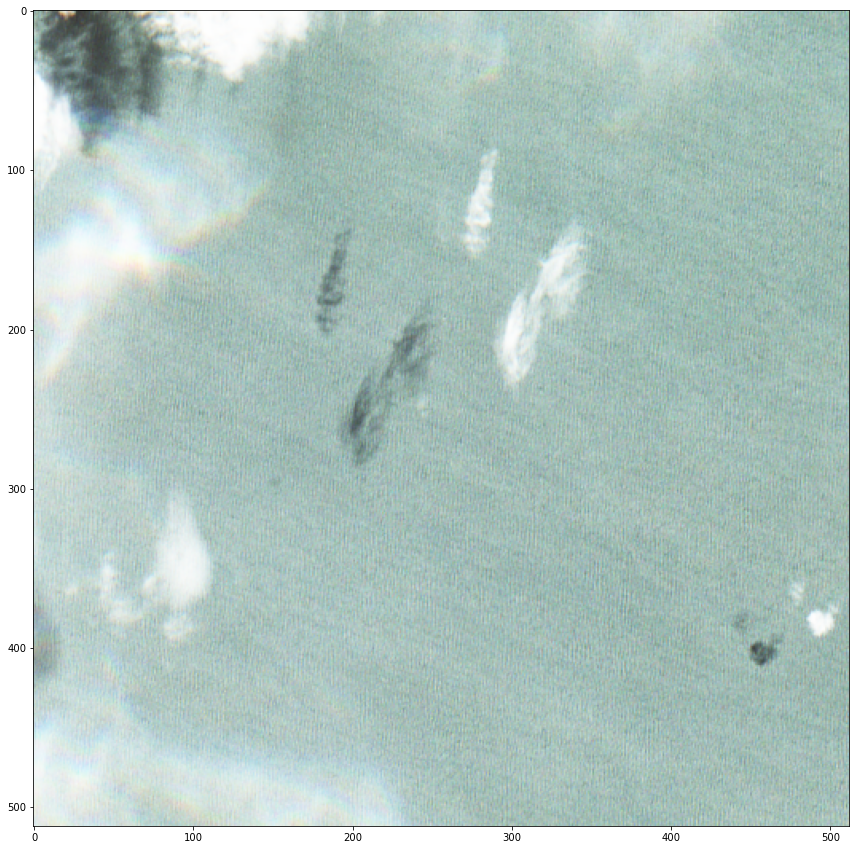

In [280]:
chip = 'aftk'
plt.figure(figsize = (20,15))
img = true_color_img(chip)
mask = mask_img(chip)
print(mask.sum())
plt.imshow(img)
#plt.imshow(mask, alpha = 0.3)
plt.show()

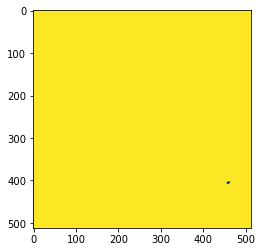

In [279]:
plt.imshow(mask)

In [266]:
cv2.findContours??

In [273]:
normal_img = np.array(img / 255)
normal_img[...,2] *= (1 - 0.3 * mask)
#normal_img[np.where(contour)] = (1,1,0,1)

In [274]:
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [277]:
plt.figure(figsize = (20,15))
plt.imshow(cv2.drawContours(normal_img, contours, -1, (0,255,0), 3))

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'drawContours'
> Overload resolution failed:
>  - image is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'image'


<Figure size 1440x1080 with 0 Axes>

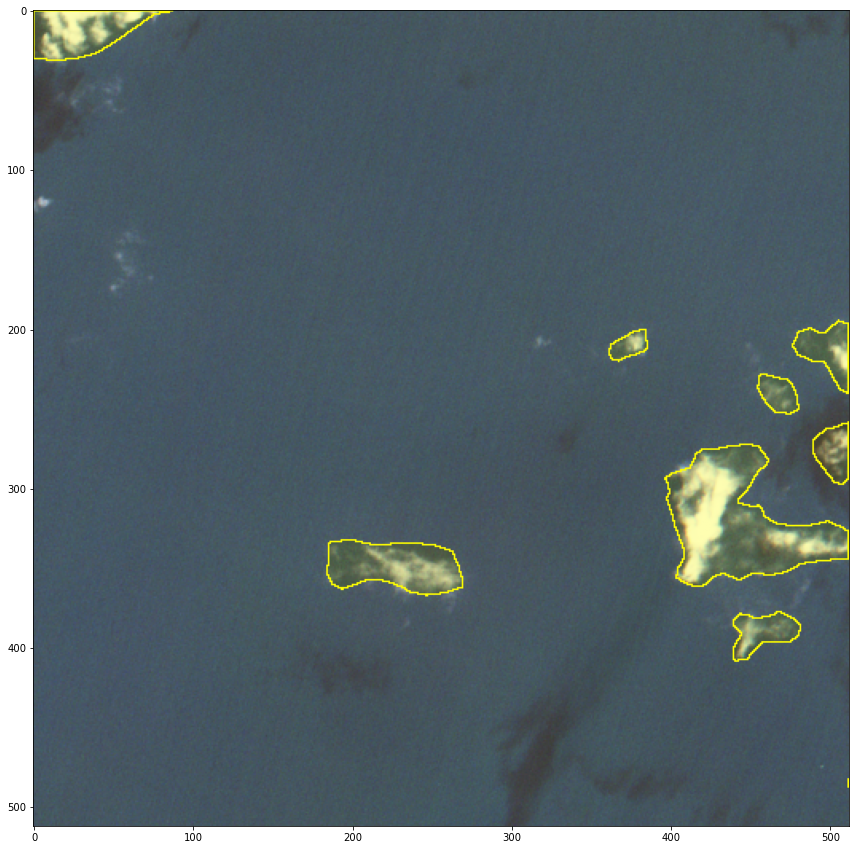

In [229]:
plt.figure(figsize = (20, 15))
plt.imshow(normal_img)

In [205]:
from PIL import ImageFilter

In [211]:
contour = np.array(Image.fromarray(mask).filter(ImageFilter.FIND_EDGES))

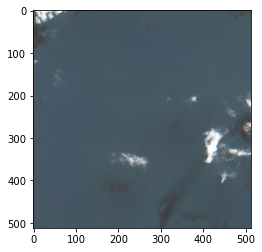

In [198]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


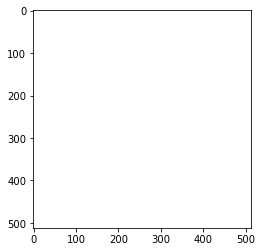

In [173]:
plt.imshow(img * intensity)

In [158]:
np.array(img).reshape(-1,4)[filter_mask]

array([[ 80,  97, 110, 255],
       [ 79, 111, 105, 255],
       [ 79,  93, 103, 255],
       ...,
       [ 70,  84,  99, 255],
       [ 69,  86,  98, 255],
       [ 66,  88,  92, 255]], dtype=uint8)

In [160]:
np.array([[1,1],[1,1]]) * np.array([[1,0],[0,0]])

array([[1, 0],
       [0, 0]])

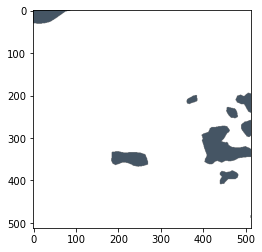

In [144]:
plt.imshow((np.array(img).reshape(-1,4)[flat_mask]).reshape((512,512,4)))

### Save dataframe

In [ ]:
#df.to_csv('data/train_ready.csv', index=False)

---

In [8]:
example_chip = train_meta[train_meta["chip_id"] == "adxp"]

display(example_chip)

chip_id  location              datetime                   cloudpath  \
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp   

   is_valid                          B02_path  \
3     False  data/train_features/adxp/B02.tif   

                           B03_path                          B04_path  \
3  data/train_features/adxp/B03.tif  data/train_features/adxp/B04.tif   

                           B08_path                  label_path  
3  data/train_features/adxp/B08.tif  data/train_labels/adxp.tif

In [9]:
example_chip = example_chip.iloc[0]
with rasterio.open(example_chip["B04_path"]) as img:
    chip_metadata = img.meta
    img_array = img.read(1)

chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32736),
 'transform': Affine(10.0, 0.0, 415340.0,
        0.0, -10.0, 9777630.0)}

In [10]:
print(img_array.min(), img_array.max())

6676 12416


In [ ]:
plt.figure(figsize = (20,15))
plt.imshow(img_array)

In [54]:
def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(chip_id, data_dir=img_path):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    chip_dir = data_dir / chip_id
    red = get_xarray(chip_dir / "B04.tif")
    green = get_xarray(chip_dir / "B03.tif")
    blue = get_xarray(chip_dir / "B02.tif")

    return ms.true_color(r=red, g=green, b=blue)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
im = true_color_img(example_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip id {example_chip.chip_id}")

In [ ]:
def display_random_chip(random_state = None):
    fig, ax = plt.subplots(1, 2, figsize=(20, 15))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]
    ax[0].imshow(true_color_img(random_chip.chip_id))
    ax[0].set_title(f"Chip {random_chip.chip_id}\n(Location: {random_chip.location})")
    label_im = Image.open(random_chip.label_path)
    ax[1].imshow(label_im)
    ax[1].set_title(f"Chip {random_chip.chip_id} label")

    plt.tight_layout()
    plt.show()

In [ ]:
display_random_chip()

# Fastai Try

In [1]:
from fastai.vision.all import *

In [2]:
df = pd.read_csv('data/train_ready.csv')
img_path = Path('data/train_features/')
mask_path = Path('data/train_labels/')

In [3]:
df.head(1)

chip_id  location              datetime                   cloudpath  \
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp   

   is_valid                          B02_path  \
0     False  data/train_features/adwp/B02.tif   

                           B03_path                          B04_path  \
0  data/train_features/adwp/B03.tif  data/train_features/adwp/B04.tif   

                           B08_path                  label_path  
0  data/train_features/adwp/B08.tif  data/train_labels/adwp.tif

In [4]:
def get_mask(folder):
    return mask_path / folder.with_suffix('.tif').name

In [5]:
def get_4chan(fold):
    ims = get_image_files(fold)
    arrs = ims.map(Image.open).map(np.array)
    stack = (np.stack(arrs, axis = -1) / 16000 * 255).astype(np.uint8)
    assert(stack.shape[-1] == 4)
    
    return PILImage.create(stack)

In [6]:
FourChanImageBlock = TransformBlock(type_tfms = get_4chan, batch_tfms = IntToFloatTensor)

In [7]:
db = DataBlock(
    blocks = (FourChanImageBlock, MaskBlock),
    get_x = ColReader('chip_id', pref = img_path),
    get_y = ColReader('label_path'),
    splitter = ColSplitter()
)

In [14]:
dls = db.dataloaders(df, bs = 2)

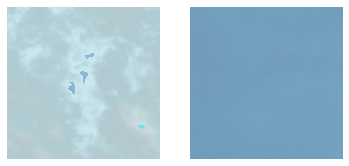

In [15]:
dls.show_batch()

In [16]:
img_size = dls.one_batch()[0].shape[-2:]

model = create_unet_model(
    arch = resnet34,
    n_out = 2,
    img_size = img_size,
    n_in = 4
)

_default_meta    = {'cut':None, 'split':default_split}
meta = model_meta.get(resnet34, _default_meta)

learn = Learner(
    dls,
    model,
    metrics = [Dice, JaccardCoeff],
    splitter = meta['split']
)

learn.freeze()

SuggestedLRs(valley=0.0002290867705596611)

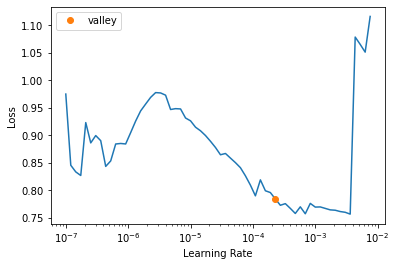

In [17]:
learn.lr_find()

In [18]:
learn.fine_tune(3, 1e-4)

In [19]:
learn.save('premature')

Path('models/premature.pth')

SuggestedLRs(valley=1.5848931980144698e-06)

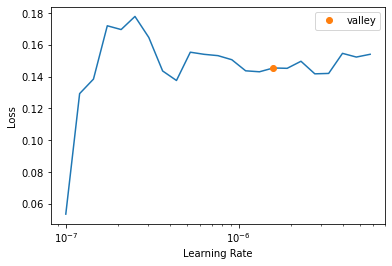

In [20]:
learn.lr_find()

In [21]:
learn.export('premature_learner')

In [23]:
learn.fit_one_cycle(5, slice(3e-7, 1e-5))

In [24]:
learn.export('res34_512_j880')